In [ ]:
#import section 
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#data sets

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
inference = pd.read_csv('data/inference.csv')

# Load the model
model = joblib.load("models/imu_pipeline.pkl")


signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

Matplotlib is building the font cache; this may take a moment.


In [67]:

# Load labels
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

In [ ]:
print(train.shape)

(800, 61)


In [69]:
labels['label']

0      collision
1      collision
2      collision
3      collision
4      collision
         ...    
468       normal
469       normal
470       normal
471       normal
472       normal
Name: label, Length: 473, dtype: object

In [5]:
print(train.head())
print(train.columns)

     x_mean     x_std     x_max     x_min   x_range    x_skew  x_kurtosis  \
0  0.057289  0.140447  0.265758 -0.214983  0.480742 -0.388161   -1.292653   
1  0.058397  0.147305  0.315987 -0.237875  0.553862 -0.371543   -1.247677   
2  0.063098  0.142273  0.286458 -0.251507  0.537965 -0.402311   -1.219693   
3  0.063224  0.145902  0.269869 -0.217910  0.487779 -0.404664   -1.292764   
4  0.060888  0.147204  0.286798 -0.249549  0.536347 -0.334129   -1.293798   

   x_n_peaks  x_energy    y_mean  ...  temperature  humidity  altitude  \
0         17  2.300756  0.014241  ...           20        46       409   
1         12  2.510906  0.015394  ...           18        34       632   
2         19  2.422294  0.015796  ...           16        49       941   
3         15  2.528467  0.039012  ...           16        47       805   
4         18  2.537652  0.017284  ...           32        36       201   

   session_id  firmware_version  calibration_status  battery_level  \
0     S607704         

In [12]:
! py -3.11 -m pip install seaborn

     -------------------------------------- 294.9/294.9 kB 1.4 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Plot distributions for X, Y, Z mean values just for inital "sense" of the data 


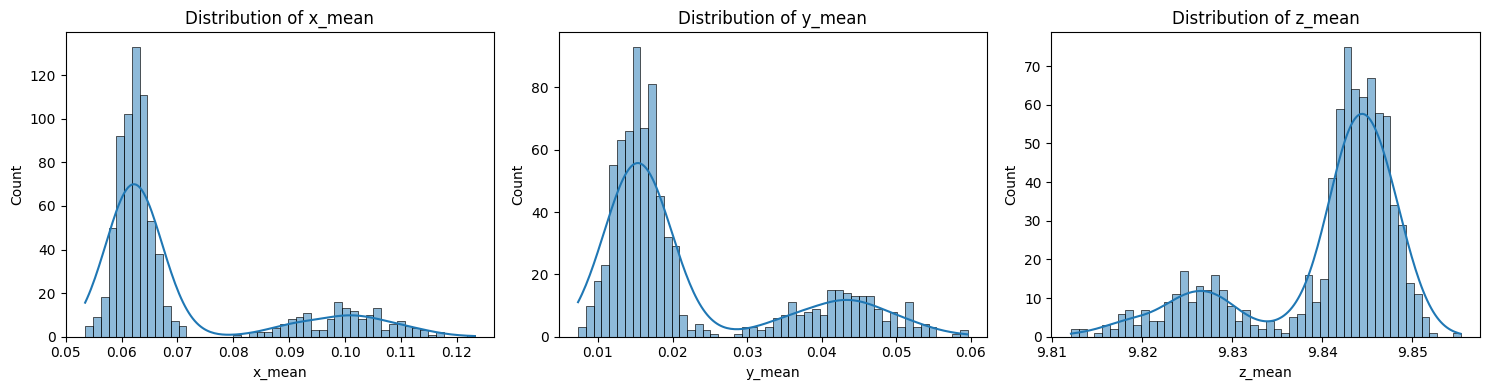

           x_mean      y_mean      z_mean
count  800.000000  800.000000  800.000000
mean     0.069947    0.022268    9.840410
std      0.015884    0.012597    0.008609
min      0.053458    0.007331    9.812097
25%      0.060799    0.013986    9.838998
50%      0.063135    0.016748    9.843367
75%      0.066828    0.024824    9.845980
max      0.123229    0.059558    9.855362


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 4))
for i, axis in enumerate(['x_mean', 'y_mean', 'z_mean']):
    plt.subplot(1, 3, i+1)
    sns.histplot(train[axis], bins=50, kde=True)
    plt.title(f'Distribution of {axis}')
plt.tight_layout()
plt.show()

# Check for outliers or strange values
print(train[['x_mean', 'y_mean', 'z_mean']].describe())

#### after reading more about the AXES and their data , seems that : 

X measures acceleration according to the X axis( horizontal) and is basically Gas/Break. Its values seems reasonable and are distributed near 0. 

Y is the "vertical acceleration" and basically measures right/left turns . Again , as long as not too sharp turns are expected- the data is near 0 , it's expected and no sign of irregularity. 

Z is acceleraiton in the 3rd dimention, meaning - hight (vertical?). This will be close to 9.8 and this is like the 0 in the [x,y] axes since default "acceleration" in the Z axis is GRAVITY - 9.8 /sec/sec (or 9.8/sec^2)

Since we measure acceleration across axes, 9.8 is enough (in terms of measurement units) and this value (close to G) is what we would expect. Diversions from this value point on bump or small elevation above the ground. 

Will be searching for a Z max and try to see other datas just to refelect on hwat happens when G is getting too variance (Harry Potter- flying car style? )

So far, no anomalies, just researching data.  

### Let's predict and evaluate the **test/inference** and compare them, as tasked in the assigment 

In [ ]:
# assign vars 
test_labels = test['label']
X_test = test.drop(columns=['label'])
y_test = test['label']
y_inference = labels['label']

#predict inference set
preds = model.predict(inference)
probs = model.predict_proba(inference)
# Predict test set
test_preds = model.predict(X_test)

# Eval function
def print_metrics(y_true, y_pred, name):
    print(name)
    print()
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, pos_label='collision')) 
    print("Recall:", recall_score(y_true, y_pred, pos_label='collision'))
    print("F1 Score:", f1_score(y_true, y_pred, pos_label='collision'))
    print()

# Apply
print_metrics(y_test, test_preds, "Test Set")
print_metrics(y_inference, preds, "Inference Set")

Test Set

Accuracy: 0.945
Precision: 1.0
Recall: 0.89
F1 Score: 0.9417989417989417

Inference Set

Accuracy: 0.4714587737843552
Precision: 0.4817708333333333
Recall: 0.7838983050847458
F1 Score: 0.5967741935483871



#### I can see indeed a significant degrade of performance ....

# EDA in search for a lead for the performance degration

### some more DIST plots

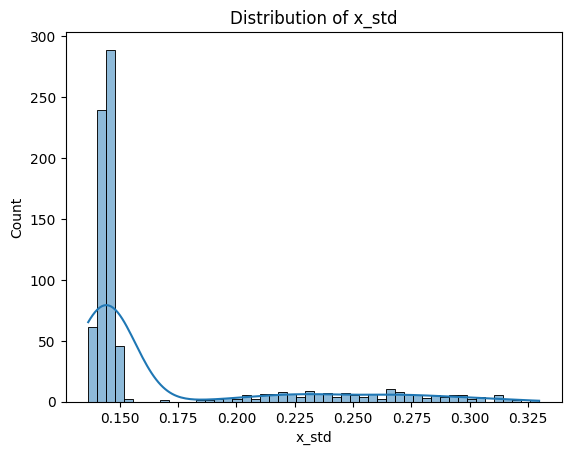

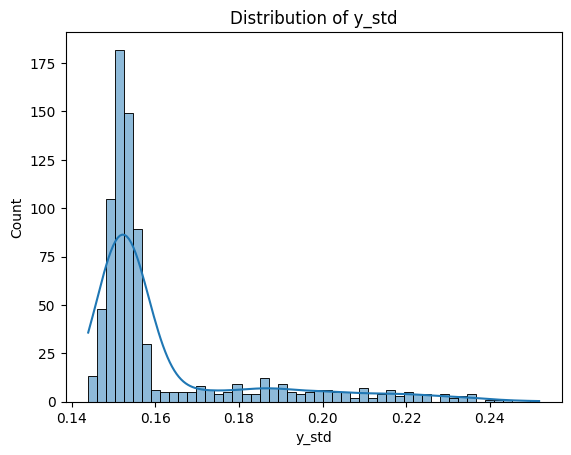

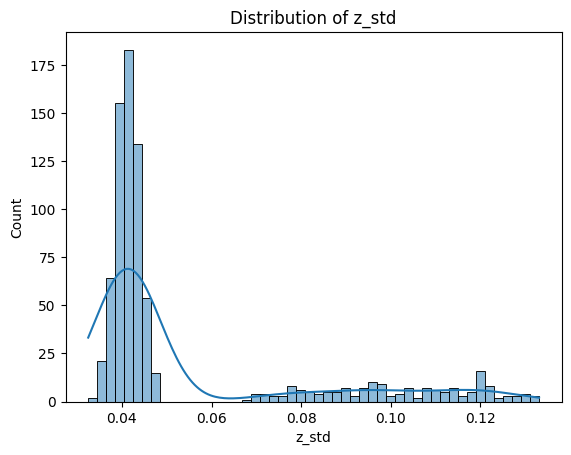

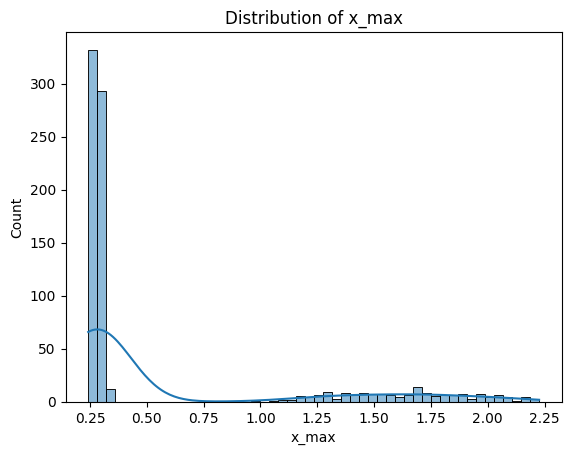

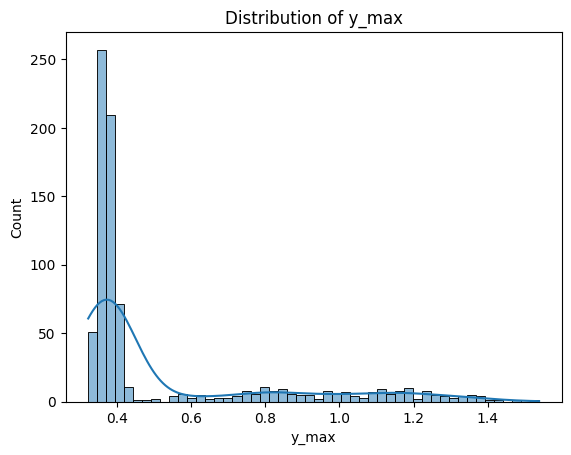

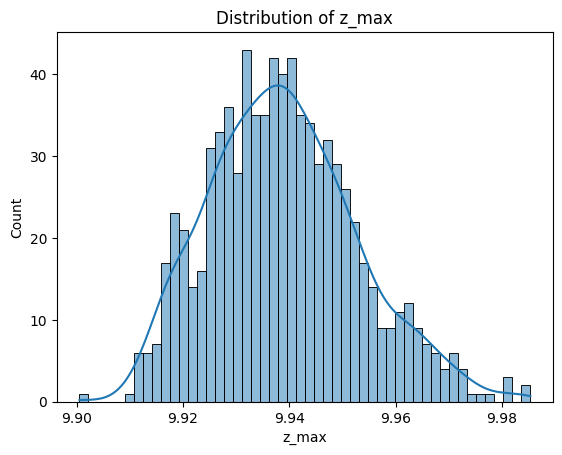

In [ ]:
for feature in ['x_std', 'y_std', 'z_std', 'x_max', 'y_max', 'z_max']:
    sns.histplot(train[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

#### mayeb it's too big , but always aim to find small spots in a data distribution 

In [16]:
print(train.describe())

           x_mean       x_std       x_max       x_min     x_range      x_skew  \
count  800.000000  800.000000  800.000000  800.000000  800.000000  800.000000   
mean     0.069947    0.166067    0.556487   -0.220334    0.776821    0.303161   
std      0.015884    0.046038    0.559195    0.018115    0.559766    1.374389   
min      0.053458    0.136440    0.242173   -0.288029    0.435227   -0.504575   
25%      0.060799    0.142913    0.272609   -0.231597    0.489602   -0.394057   
50%      0.063135    0.145228    0.286315   -0.217763    0.508313   -0.359562   
75%      0.066828    0.148452    0.308723   -0.206689    0.542570   -0.308249   
max      0.123229    0.329744    2.225958   -0.179317    2.463422    4.341129   

       x_kurtosis   x_n_peaks    x_energy      y_mean  ...   z_fft_max  \
count  800.000000  800.000000  800.000000  800.000000  ...  800.000000   
mean     1.937158   13.567500    3.483957    0.022268  ...  984.041021   
std      6.623564    5.052955    2.179326    0.0

### Let's explore "flying car" for a second

I will now check the highest observations of axis_MAX for the entrie training data and see its coresponding label

In [78]:
for axis in ['x', 'y', 'z']:
    col = f'{axis}_max'
    idx = train[col].idxmax() # func that is used to retrieve the index of the maximum value in a column
    print(f"\nHighest {col}: {train.loc[idx, col]}, Label: {train.loc[idx, 'label']}")


Highest x_max: 2.2259578812975835, Label: collision

Highest y_max: 1.5382799247933217, Label: collision

Highest z_max: 9.985372373685973, Label: normal


intersting ... seems that Z remains almost the same and the max observation has normal label while the other max tilt in the X,Y axes ended in collision...

calculating mean of mean_AXIS to compare deviation

In [77]:
mean_means = {axis: train[f'{axis}_mean'].mean() for axis in ['x', 'y', 'z']}
print(" ------ Mean of means for each axis: \n")
for axis, mean_val in mean_means.items():
    print(f"{axis.upper()} mean: {mean_val}")

 ------ Mean of means for each axis: 

X mean: 0.06994670460935505
Y mean: 0.02226784620048066
Z mean: 9.840410213752943


Indeed , the deviation of XY is way higher while Z is barely moving . So we can say that Z movement is almost neglectable and I may assume it may have 0 impact on the final model. I will shortly re-run the model without ANY Z data and see performance change 

But first , I want to visual the **top 30 high** observations across **X,Y** axes and its **corresponding labels**. 

In [80]:
for axis in ['x', 'y']:
    col = f'{axis}_max'
    print(f"\nTop 30 observations with highest {col}:\n")
    top = train.nlargest(30, col)[[col, 'label']]
    print(top)


Top 30 observations with highest x_max:

        x_max      label
562  2.225958  collision
590  2.220999  collision
669  2.219310  collision
400  2.165130  collision
186  2.164319  collision
180  2.154964  collision
407  2.148085  collision
408  2.118925  collision
433  2.104355  collision
284  2.092651  collision
206  2.085266  collision
592  2.074861  collision
275  2.062517  collision
121  2.050936  collision
320  2.050894  collision
16   2.045034  collision
225  2.036017  collision
55   2.028301  collision
273  2.023163  collision
402  2.018856  collision
660  2.014388  collision
45   2.010120  collision
17   1.987124  collision
584  1.987060  collision
198  1.982699  collision
250  1.967879  collision
199  1.966351  collision
589  1.965268  collision
272  1.948731  collision
686  1.941218  collision

Top 30 observations with highest y_max:

        y_max      label
407  1.538280  collision
261  1.472129  collision
611  1.440850  collision
457  1.414560  collision
584  1.386003  c

### BOOM! 
collision in each one of the samples

Let's see the buttom 30 and their corresponding label

In [83]:
#printing mean here again to compare observation's deviation

print(" ------ Mean of means for each axis: \n")
for axis, mean_val in mean_means.items():
    print(f"{axis.upper()} mean: {mean_val}")

# bottom lowest observations  
for axis in ['x', 'y', 'z']:
    col = f'{axis}_min'
    print(f"\nTop 30 samples with lowest {col}:")
    bottom = train.nsmallest(30, col)[[col, 'label']]
    print(bottom)

 ------ Mean of means for each axis: 

X mean: 0.06994670460935505
Y mean: 0.02226784620048066
Z mean: 9.840410213752943

Top 30 samples with lowest x_min:
        x_min      label
195 -0.288029  collision
82  -0.287254     normal
608 -0.283748  collision
333 -0.282355     normal
604 -0.281442  collision
391 -0.278764     normal
614 -0.278371     normal
426 -0.276600     normal
116 -0.275149  collision
660 -0.272262  collision
671 -0.271489     normal
330 -0.271387     normal
293 -0.270949  collision
707 -0.265190  collision
250 -0.263279  collision
30  -0.262781  collision
167 -0.262468     normal
340 -0.262316     normal
211 -0.262168     normal
35  -0.260997  collision
63  -0.259549  collision
289 -0.259120  collision
689 -0.258987     normal
549 -0.258050  collision
702 -0.257873  collision
107 -0.257759  collision
321 -0.257348  collision
556 -0.256901     normal
192 -0.256513  collision
599 -0.256251     normal

Top 30 samples with lowest y_min:
        y_min      label
288 -0.35

#### On **bottom** of X/Y axes,  labels are distributed kind of equeally between "normal" and "collision" 

#### Z on the other hand, seems hihgly probable of **coliding** when reaching MIN Z values, (just like x/y on MAX) ... Seems that Z is not useless as I assumed just due to distributing the MAX values and not the MIN 



#### Checking about the natrue of XYZ datas 

Z > 9.8: The car experienced an upward acceleration greater than gravity.
This can happen if the car goes over a bump or is briefly airborne.
Z ≈ 8.3: The vertical acceleration is much less than gravity. This suggests the car is falling or dropping or the car is in free fall for a moment.

#### therefore I can deduce that the reason why min Z values are "deadly" is becasue they represent slightly **flying** moment, which is obviously dangerous and are near collision.

#### Y 
Standard convention: Positive Y is usually a left turn, negative Y is a right turn.
Here, the positive Y (left) is much more dangerous so I assume that the data is taken from countries that are driving in the right lane and that LEFT is used for bypass which is more correlated with dangers. 

#### X

Positive X: Acceleration 
Negative X: Braking 

Postive X is highly correlated with collision. Indeed , on events of high (max) press on gas - not so good things are expected... 
However, seems like collisions will be associated with strong stopping movement (min X values ) and maybe indeed the min values with the label collision represent that, but also many coliisions are prevented due to strong break- min X values. 

Nice research, let's move on



In [ ]:
#lookking for metadata columns to search for geolocation 
train.columns[30:]

Index(['max_delta_mag', 'sudden_change_score', 'x_fft_max', 'x_fft_mean',
       'y_fft_max', 'y_fft_mean', 'z_fft_max', 'z_fft_mean', 'xy_corr',
       'xz_corr', 'yz_corr', 'sample_id', 'sensor_source', 'label',
       'timestamp', 'weather', 'driver_id', 'vehicle_type', 'speed_bin',
       'road_type', 'time_of_day', 'temperature', 'humidity', 'altitude',
       'session_id', 'firmware_version', 'calibration_status', 'battery_level',
       'gps_accuracy', 'network_type', 'device_model'],
      dtype='object')

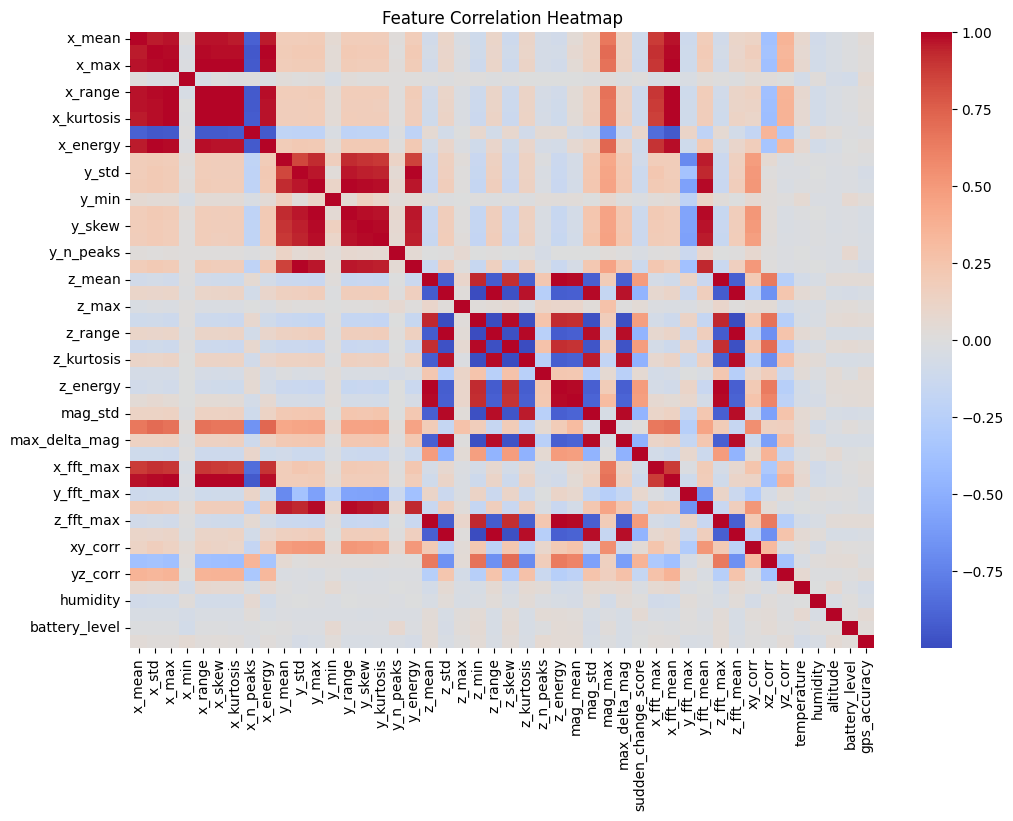

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(train.select_dtypes(include='number').corr(), cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

not so eye opennign info, let's see the datas across datasets 

## EDA XYZ's distribution **accross different datasets** 

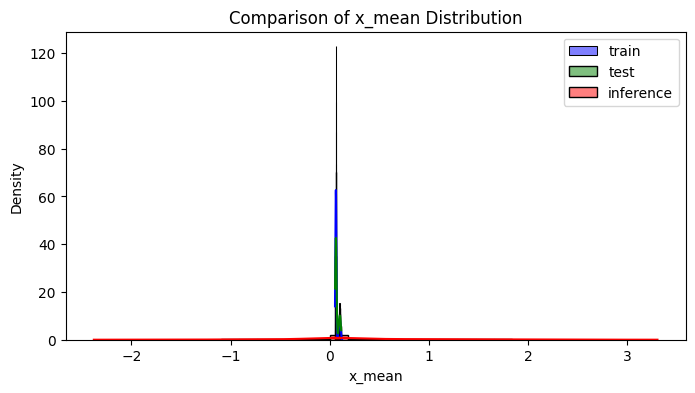

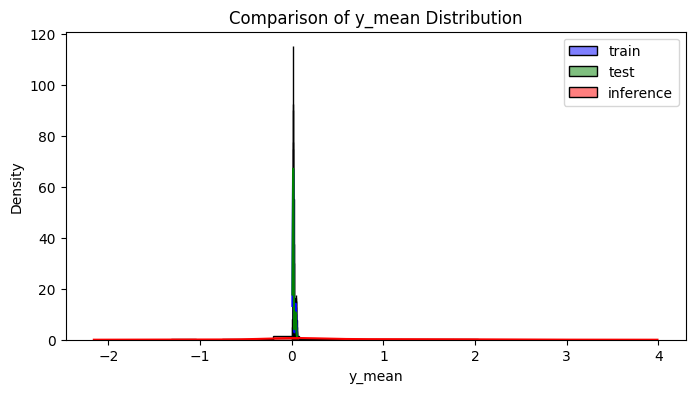

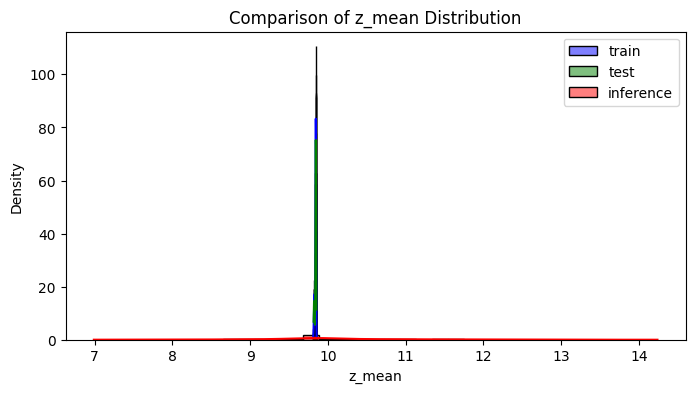

In [ ]:

#features_to_compare
features_to_compare = ['x_mean', 'y_mean', 'z_mean']

for feature in features_to_compare:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[feature], color='blue', label='train', kde=True, stat='density')
    sns.histplot(test[feature], color='green', label='test', kde=True, stat='density')
    sns.histplot(inference[feature], color='red', label='inference', kde=True, stat='density')
    plt.legend()
    plt.title(f'Comparison of {feature} Distribution')
    plt.show()

### seems uneven distribution 

## now STD & max for XYZ **per datasets**

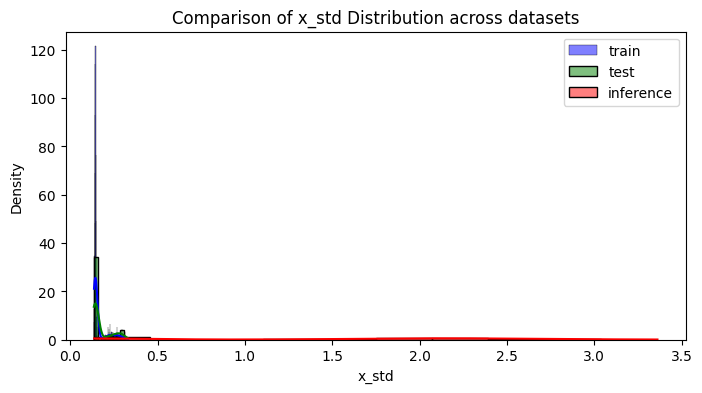

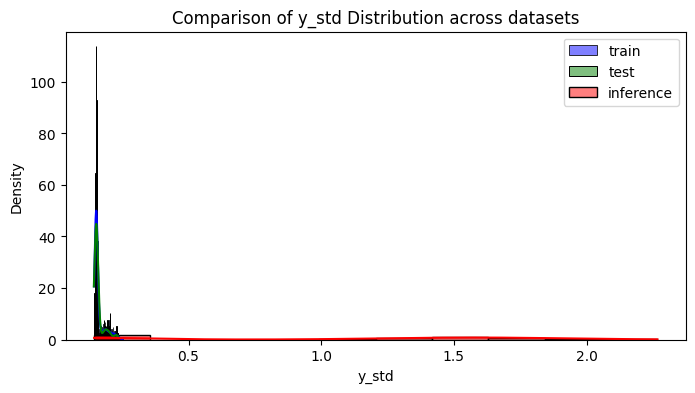

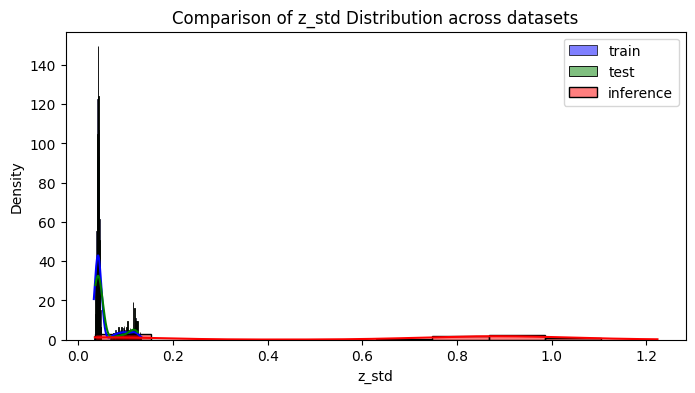

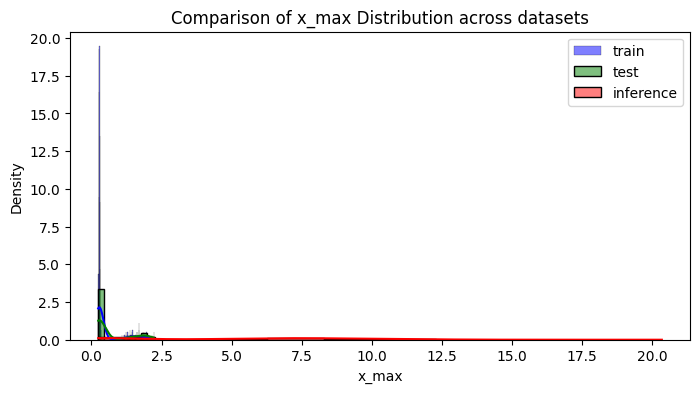

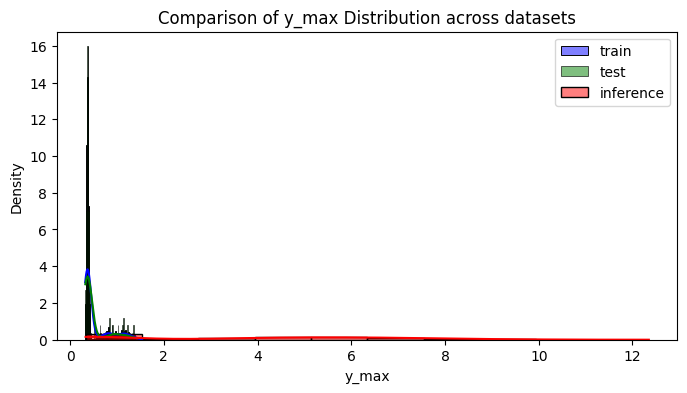

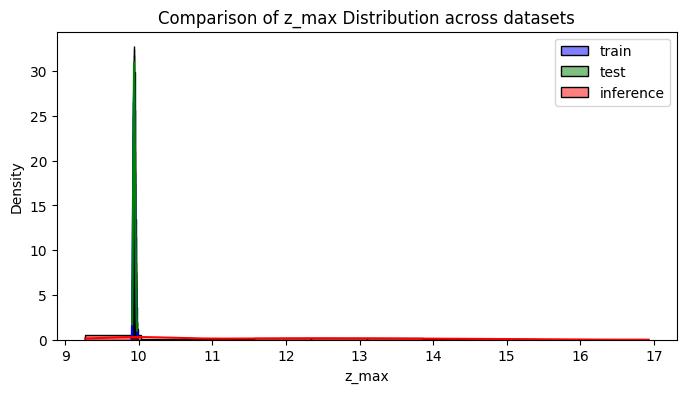

In [94]:
for feature in ['x_std', 'y_std', 'z_std', 'x_max', 'y_max', 'z_max']:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[feature], color='blue', label='train', kde=True, stat='density')
    sns.histplot(test[feature], color='green', label='test', kde=True, stat='density')
    sns.histplot(inference[feature], color='red', label='inference', kde=True, stat='density')
    plt.legend()
    plt.title(f'Comparison of {feature} Distribution across datasets')
    plt.show()

The features for [x,y.z] in the **inference** set are **significantly different** from those in the **train and test sets**.
This indicates data was unequally splitted or **changed collection method** among sets.

This is a data drift and is likely due to:
1. Changes in driving conditions (maybe very wild drivers (formula1?) whom the data should not be used to predict upon "regular" data)
2. **sensor hardware changes**

Will search for the cause of this drift as part of the **sensor hardware**.  

 This drift is a probable cause for the observed drop in model performance on the **inference** set.


### Checking label distribution

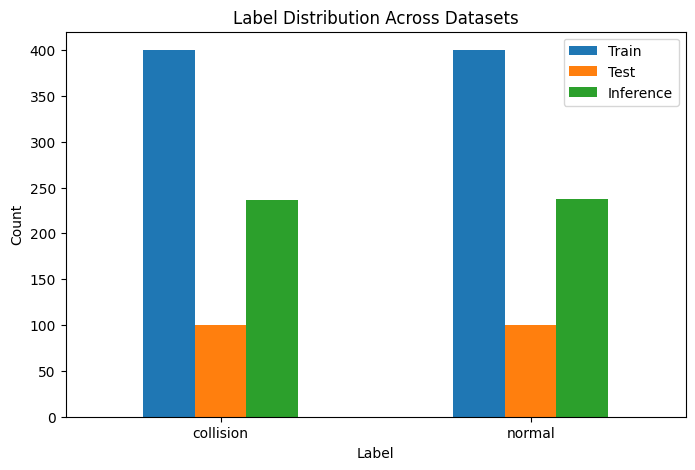

In [46]:
# Prepare counts
train_counts = train['label'].value_counts().sort_index()
test_counts = test['label'].value_counts().sort_index()
inference_counts = labels['label'].value_counts().sort_index()

# Combine into a DataFrame
label_df = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts,
    'Inference': inference_counts})

# Plot
label_df.plot(kind='bar', figsize=(8, 5))
plt.title('Label Distribution Across Datasets')
plt.ylabel('Count')
plt.xlabel('Label')
plt.xticks(rotation=0)
plt.show()

### Seems that the distribtion of labels is even !

## checking the hardware columns to validate sensors drift

In [52]:
train.columns

Index(['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis',
       'x_n_peaks', 'x_energy', 'y_mean', 'y_std', 'y_max', 'y_min', 'y_range',
       'y_skew', 'y_kurtosis', 'y_n_peaks', 'y_energy', 'z_mean', 'z_std',
       'z_max', 'z_min', 'z_range', 'z_skew', 'z_kurtosis', 'z_n_peaks',
       'z_energy', 'mag_mean', 'mag_std', 'mag_max', 'max_delta_mag',
       'sudden_change_score', 'x_fft_max', 'x_fft_mean', 'y_fft_max',
       'y_fft_mean', 'z_fft_max', 'z_fft_mean', 'xy_corr', 'xz_corr',
       'yz_corr', 'sample_id', 'sensor_source', 'label', 'timestamp',
       'weather', 'driver_id', 'vehicle_type', 'speed_bin', 'road_type',
       'time_of_day', 'temperature', 'humidity', 'altitude', 'session_id',
       'firmware_version', 'calibration_status', 'battery_level',
       'gps_accuracy', 'network_type', 'device_model'],
      dtype='object')

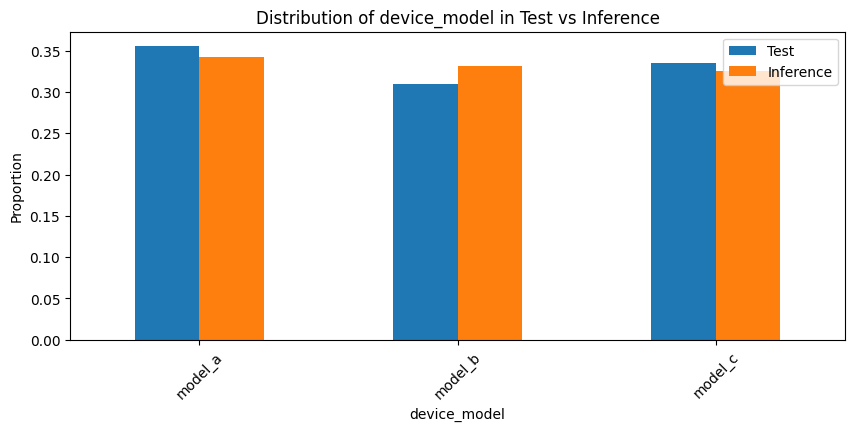

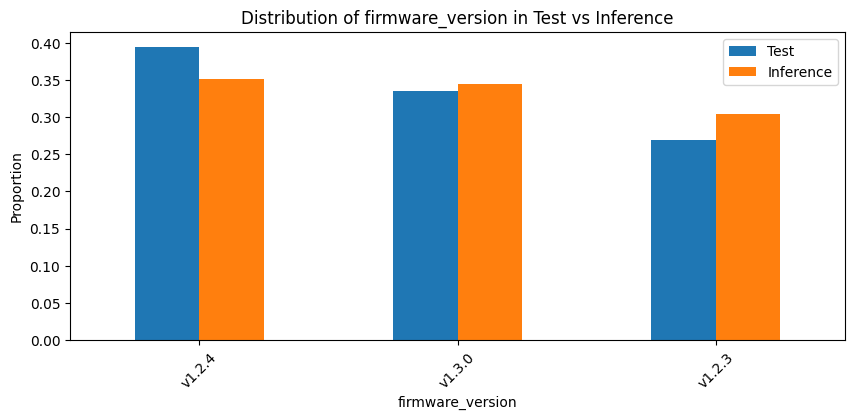

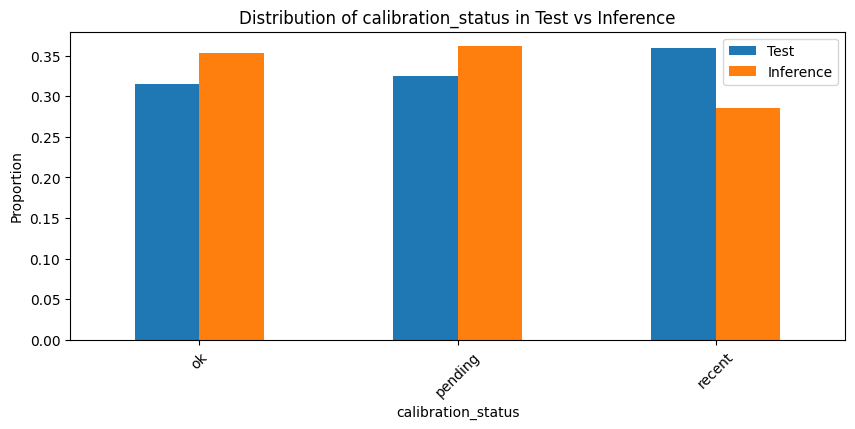

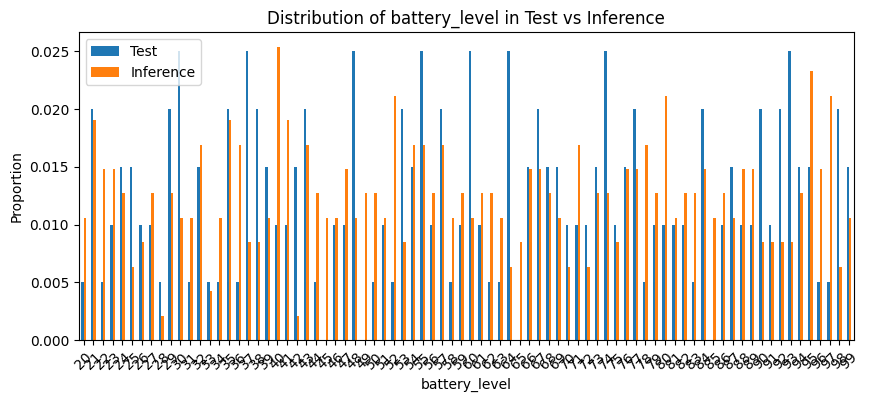

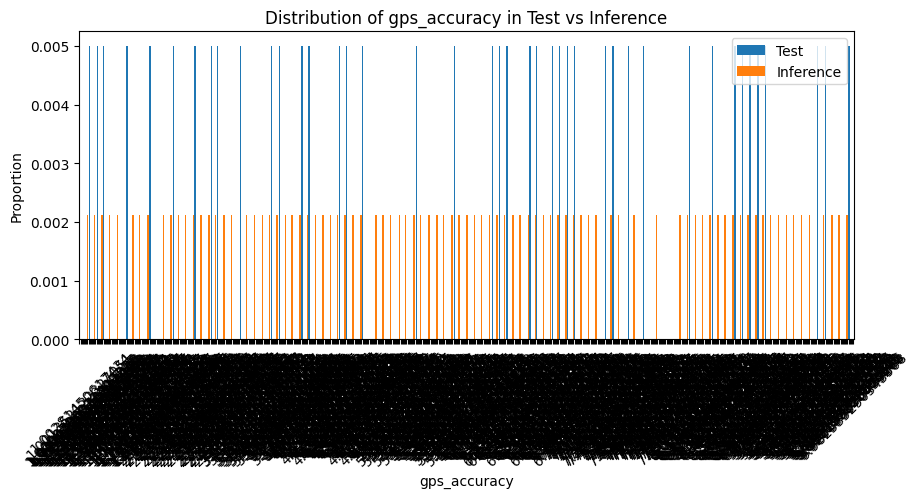

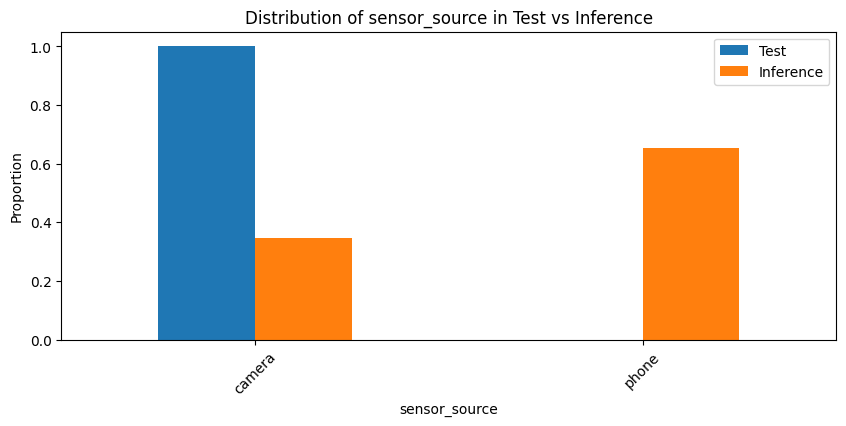

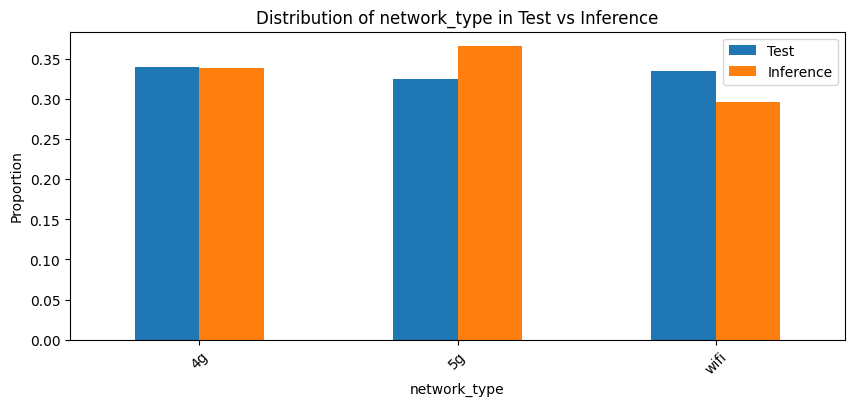

In [62]:
cols_to_check = [
    'device_model', 'firmware_version', 'calibration_status',
    'battery_level', 'gps_accuracy', 'sensor_source', 'network_type'
]

for col in cols_to_check:
    
    plt.figure(figsize=(10, 4))
    test_counts = test[col].value_counts(normalize=True)
    inf_counts = inference[col].value_counts(normalize=True)
    df_compare = pd.DataFrame({'Test': test_counts, 'Inference': inf_counts}).fillna(0)
    df_compare.plot(kind='bar', ax=plt.gca())
    plt.title(f'Distribution of {col} in Test vs Inference')
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.show()

From the hardware detail above, we can see that :

1. 'device_model', 'firmware_version', 'network type'and 'calibration_status' are relatively equally distributed between inference and test sets and are no reason of the poor performance which we alligned with drivers segmentations or SENSORS (what I checked now )

2. GPS and battery are currently sequential columsn and need to be transforemed into CATEGORIAL to check "drifting" and  I will skip it for now.

3. Sensor source is defientley biased in the inference set and is likely the cause of why the data are so different and therefore , the valuation matrixes are such way off the test's performances.

MID CONCLUSION - SENSOR DATA IS BIASED AND CAUSED THE POOR PERFORMANCE

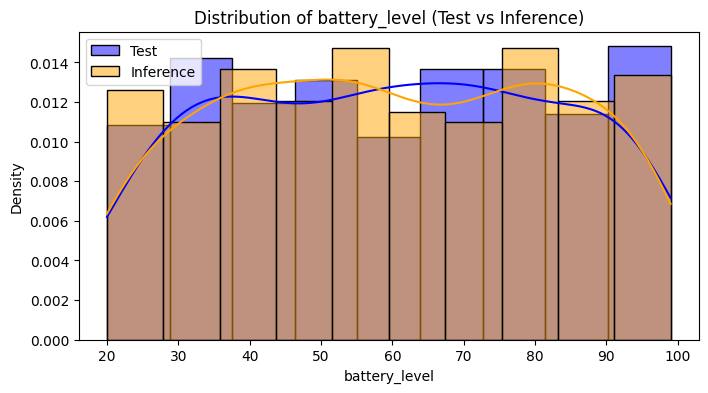

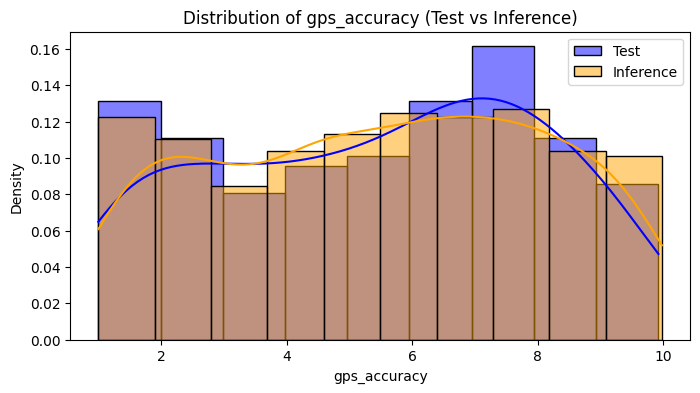

In [63]:
for feature in ['battery_level', 'gps_accuracy']:
    plt.figure(figsize=(8, 4))
    sns.histplot(test[feature], color='blue', label='Test', kde=True, stat='density')
    sns.histplot(inference[feature], color='orange', label='Inference', kde=True, stat='density')
    plt.legend()
    plt.title(f'Distribution of {feature} (Test vs Inference)')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

seems that other factors of hardware affect here but the main issue derives from the device quality 

# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

- Is there anything in the data that might explain differences in behavior?

- Can you identify patterns or trends related to when the model succeeds or fails?

- Are there signals or features that seem to affect the model’s reliability?

- What could be done in the short term to handle the current situation?

- What are potential long-term steps to improve model performance in similar scenarios?

- What would you want to explore further if given more time or data?

- What assumptions did the model rely on during training — and are they still valid?

# Answers

1. observation of comparison: 

    The performance are worsen dramaticlaly :

    Test : Accuracy: 0.945 Precision: 1.0 Recall: 0.89 F1: 0.9417

    Inference:  Accuracy: 0.471 Prec: 0.481  Recall: 0.783 F1: 0.596

2. Anomallies?  

    Yes, seems that the distribution of variance of the 3 axes [xyz] across datasets are uneven.

3. patterns

    Given the annomallies which point on much vatiant data and after analysis of hardware seems unequal distribution of sensor data among 'test' and 'inference' sets. 
    This means that the data was deisigned to train with (and test) is not ideal for new observations from iphones source. 

4. Other features 

     Yes, sensor data , GPS accuracy and battery level are all relatively high differentiating between the 2 data sets ('inference' and 'test')
    Since I believe that the other 2 are derived from the kind of sensor, I cocnlude that the mean issue here is the sensor , and upon providing equal data or train on phone data alone - better results will appear. 

5. Short term

    - Retrain model on phone data only and see results on inference . 
    - Flag smaples that came only from phone and predict via the new specific sensor model.


6. long term

     - provide more data from both sensors (better more quality data unless we need to mimic real users's needs and then most have smartphones and therefore just retrain on both and collect MORE data)
     - Regularly monitor for data drift and update the model accordingly.
     - I will add a warnning to warn the user when predicting such data and provide a minimum threshold to only accept the predcitions from.
       

7. Further exploration 

    I may:
    -  re-evaluate on data just on phone source and see the results. 
    - Also, devide "phone" to categories by  manufacturer (iphone, galaxy, xiomi) and see which one gives qulaity and more relaible data (GPS accuracy/ battery etc) and then rely on phone data which is valid and then mimic "real world users's" needs if only one phone manufucturer provides such accuracy.
    - Test drivers segmentioan to check drivers's background and geographoc area as impactful factors over the sensors data.
    - Explore advanced drift detection and model adaptation techniques.

8. Model assumptions 

    The model assumed the inference data would have similar feature distributions and sensor sources as the training data. This assumption is NOT VALID now, as shown by the significant drift in metadata and signal features.

